## Quantum Black Holes - Time Delay ##
Suzanne Parr, Group 4

The research goal is to understand how quantum corrections affect the deflection angle, $\hat{\alpha}$, as light is deflected by a black hole. We assume the observer, source, and black hole all lie in the equatorial plane ($\theta = \frac{\pi}{2}$). For light, $\epsilon = 0$ where epsilon is the "constant of motion". At $r = r_0$, the closest approach to the black hole, $\frac{dr}{d\phi} = 0$ and also $\frac{dr}{d\lambda} = 0$. Therefore the radial equation,

$$\left( \frac{dr}{d\lambda} \right)^2 = \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right)$$

at $r = r_0$ becomes, $\frac{E^2}{L^2} = \frac{f(r_0)}{h(r_0)}$. Therefore if we set L = 3.8 and $r_0 = 3.75$ we can solve for E for each value of $Q_b$ and, if we have the same initial $t, r, \phi$, we can plot superimposed trajectories to visually and numerically compare $\hat{\alpha}$. Substituting $\frac{E^2}{L^2}$ into the expression for $\frac{dr}{d\phi}$ we get,

$$\frac{d\phi}{dr} = \sqrt{ \frac{h(r)}{g(r)} \left( \frac{h(r)}{h(r_0)} \cdot \frac{f(r_0)}{f(r)} - 1 \right) }$$

We can integrate to get the effective deflection angle, $\hat{\alpha}$:

$$\hat{\alpha}(r_0) = 2 \int_{r_0}^{\infty} dr \, \sqrt{ \frac{h(r)}{g(r)} \left( \frac{h(r)}{h(r_0)} \cdot \frac{f(r_0)}{f(r)} - 1 \right) } - n\pi$$

Instead I will use my integration function to get arrays, $r(\lambda), \phi(\lambda)$, which I will use to plot $r(\phi)$ for each value of $Q_b$ and calculate $\hat{\alpha}$.

In [50]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.interpolate import interp1d

# Particle Motion in the improved Schwarzschild Metric #

To plot trajectories, start with the Point Particle Lagrangian (describes particle motion in a SC spacetime):

$$L = g_{\mu\nu} \dot{x}^\mu \dot{x}^\nu = -f(r)\dot{t}^2 + g(r)\dot{r}^2 + h(r)\left( \dot{\theta}^2 + \sin^2(\theta)\dot{\phi}^2 \right)$$

Spherical symmetry means we can confine motion to the equatorial plane and if we integrate once (with respect to $\theta$), we get 3 components of motion that we can solve to get $r(\phi)$,

$$\frac{dt}{d\lambda} = \frac{E}{f(r)}$$

$$\frac{d\phi}{d\lambda} = \frac{L}{h(r)}$$

$$\left( \frac{dr}{d\lambda} \right)^2 = \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right)$$

The quantum corrections, $Q_b$ and $Q_c$, for the improved metric are built into the metric functions. If we re-arrange the radial component to isolate $E^2$ we can "read off" the Effective Potential,

$$V_{\text{eff}}(r) = f(r) \left( \frac{L^2}{h(r)} + \epsilon \right)$$

Below we define the metric functions and Effective Potential for the improved metric. 

In [51]:
# block 1 - expressions derived from the improved Schwarzschild metric

# schwarzschild radius from mass
def r_sc(M):
    return (2*M)

# improved schwarzschild metric functions (dependent on radial component, r, M, and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return (1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(np.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(np.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return f(r, M, Q_b, Q_c) * (L**2/h(r, M, Q_c) + epsilon)

# Assign Values to Constants

Assign values for Mass (M) of the black hole, Angular momentum (L) of the orbiting particle, and a set of test values for the quantum parameters (QM). For this research I chose L = 3.8. Angular momentum changes the shape of the effective potential; I picked a value that lead to well-defined trajectories for perihelion shift, light deflection. Throughout this research I chose $Q_c = 0$ since its effect is negligable and we can isolate the effect of the $Q_b$ correction.

In [52]:
# block 2 - assign test values for mass and angular momentum
M1 = 1.0  
rs1 = r_sc(M1)
L1 = 3.8 # angular momentum of orbiting particle
# test values of quantum parameters
Q_b0 = 0.0
Q_b1 = 0.25
Q_b2 = 0.5
Q_b3 = 0.75
Q_b4 = 1.0
Q_c0 = 0.0

# Plotting Trajectories

Using the function 'solve_geodesics()' we solve for $t(\lambda)$ and $r(\lambda)$ by integrating the 3 components of motion with $\lambda$ as the independent variable.

In [53]:
# Block 5 - function for inward (and outward if required) integration of components of motion
def solve_geodesic(r_init, phi_init, t_init, lam_range, params, epsilon=0, direction='inward', stop_far_out=True, r_max=60):
    E, L, M, Q_b, Q_c = params
    sign = -1 if direction == 'inward' else 1
    flipped_on_this_neg = False

    # Check squared at the initial radius
    ff0 = float(f(r_init, M, Q_b, Q_c))
    gg0 = float(g(r_init, M, Q_b, Q_c))
    hh0 = float(h(r_init, M, Q_c))

    squared0 = (1/gg0) * (E**2 / ff0 - (epsilon + L**2 / hh0))
    print("Initial squared:", squared0)

    if squared0 < 0:
        print("Warning: Initial region is classically forbidden.")
        flipped_on_this_neg = True

    def dy_dt(lam, y):
        nonlocal sign, flipped_on_this_neg

        t, r, phi = y
        r = float(r)

        ff = float(f(r, M, Q_b, Q_c))
        gg = float(g(r, M, Q_b, Q_c))
        hh = float(h(r, M, Q_c))

        squared = (1/gg) * (E**2 / ff - (epsilon + L**2 / hh))

        if squared < 0 and not flipped_on_this_neg:
            sign *= -1
            flipped_on_this_neg = True
        elif squared >= 0:
            flipped_on_this_neg = False

        dt_dlam = E / ff
        dr_dlam = sign * np.sqrt(abs(squared))
        dphi_dlam = L / r**2

        return [dt_dlam, dr_dlam, dphi_dlam]

    def horizon_event(lam, y):
        return y[1] - (2 * M)
    horizon_event.terminal = True
    horizon_event.direction = -1  # detect crossing inward

    events = [horizon_event]

    if stop_far_out:
        def escape_event(lam, y):
            return y[1] - r_max
        escape_event.terminal = True
        escape_event.direction = 1  # detect escaping outward
        events.append(escape_event)

    sol = solve_ivp(
        dy_dt,
        lam_range,
        [t_init, r_init, phi_init],
        t_eval=np.linspace(*lam_range, 2000),
        atol=1e-6,
        rtol=1e-6,
        events=events,
        max_step=0.2
    )

    for i, event in enumerate(sol.t_events):
        if len(event) > 0:
            label = 'horizon' if i == 0 else f'event {i}'
            print(f"{label} triggered at λ = {event[0]:.4f}")

    t_vals = sol.y[0]
    r_vals = sol.y[1]
    phi_vals = np.unwrap(sol.y[2])

    dt_dlam_vals = np.zeros_like(sol.t)
    dr_dlam_vals = np.zeros_like(sol.t)
    dphi_dlam_vals = np.zeros_like(sol.t)

    for i in range(len(sol.t)):
        dt_dlam, dr_dlam, dphi_dlam = dy_dt(sol.t[i], sol.y[:, i])
        dt_dlam_vals[i] = dt_dlam
        dr_dlam_vals[i] = dr_dlam
        dphi_dlam_vals[i] = dphi_dlam

    return t_vals, r_vals, phi_vals, dt_dlam_vals, dr_dlam_vals

# Selecting E values #

For light, a circular orbit is possible at the maxima if $V_{\text{max}}(r) = E^2$. For light deflection we must choose an initial r value outside $V_{\text{max}}(r)$ and travel inwards. If $E^2 > V_{\text{max}}(r)$, the light ray will be scattered after a turning point; this is what we want. However, if $E^2 < V_{\text{max}}(r)$, it will plunge into the BH. 

At the closest approach to the black hole ($r = r_0$), $\frac{dr}{d_\lambda} = 0$ and the radial expression reduces to: 

$$\frac{L^2}{E^2} = \frac{h(r_0)}{f(r_0)}$$

If we set constant values for L and $r_0$ ($L = 3.8, r_0 = 3.75$) we can solve for E for each value of $Q_b$ and put them into an array (E_vals).

In [100]:
# block 6 - select E values 
#------- get E based on a common value for r0 where (L^2 / E^2 = h(r0) / f(r0))
r0 = 3.75 # closest approach
Qc = 0.0
Qb_vals = [0.0, 0.25, 0.5, 0.75, 1.0]

# Compute E for each Qb
E_vals = []

for Qb in Qb_vals:
    f_r0 = float(f(r0, M1, Qb, Qc))
    h_r0 = float(h(r0, M1, Qc))
    E_sq = L1**2 * f_r0 / h_r0
    E = np.sqrt(E_sq)
    E_vals.append(E)
    print(f"Qb = {Qb:.2f}, E = {E:.6f}")

Qb = 0.00, E = 0.692238
Qb = 0.25, E = 0.701856
Qb = 0.50, E = 0.711374
Qb = 0.75, E = 0.720795
Qb = 1.00, E = 0.730121


## Build Time Delay datasets ##

Set initial conditions and build data arrays for $r(\lambda)$ and $\phi(\lambda)$ by calling solve_geodesics() for each pair of $Q_b$ and E values. Start integrating inwards from far out at $r = 20\,r_s$. Next superimpose all 5 light trajectories in one plot and include the inward asymptote which extends an initial linear inbound segment out beyond the black hole. It is a reference line against which to measure the effective deflection angle, $\hat{\alpha}$.

In [137]:
# block 7 - create data for light deflection
# ------- initial conditions ------ #
eps = 0.0
phi0 = 0.0
t0 = 0.0
lam_range0 = [0, 120]
r_ol = 20 * rs1 # far out starting point
# ------- classic schwarzschild case (Qb=0) ------ #
Qb0 = Qb_vals[0]
E0 = E_vals[0]

params0 = (E0, L1, M1, Qb0, Q_c0)

t_vals_0, r_vals_0, phi_vals_0, dt_dlam_0, dr_dlam_0  = solve_geodesic(r_ol, phi0, t0, lam_range0, params0, epsilon=0)

# polar to cartesian
x_vals_0 = r_vals_0 * np.cos(phi_vals_0)
y_vals_0 = r_vals_0 * np.sin(phi_vals_0)
# ------- quantum corrections (Qb=0.25) ------ #
Qb1 = Qb_vals[1]
E1 = E_vals[1]

params1 = (E1, L1, M1, Qb1, Q_c0)

t_vals_1, r_vals_1, phi_vals_1, dt_dlam_1, dr_dlam_1  = solve_geodesic(r_ol, phi0, t0, lam_range0, params1, epsilon=0)

# polar to cartesian
x_vals_1 = r_vals_1 * np.cos(phi_vals_1)
y_vals_1 = r_vals_1 * np.sin(phi_vals_1)
#--------- quantum corrections - Qb = 0.5 -------------
Qb2 = Qb_vals[2]
E2 = E_vals[2]

params2 = (E2, L1, M1, Qb2, Q_c0)

t_vals_2, r_vals_2, phi_vals_2, dt_dlam_2, dr_dlam_2 = solve_geodesic(r_ol, phi0, t0, lam_range0, params2, epsilon=0)

# polar to cartesian
x_vals_2 = r_vals_2 * np.cos(phi_vals_2)
y_vals_2 = r_vals_2 * np.sin(phi_vals_2)
#--------- quantum corrections - Qb = 0.75 -------------
Qb3 = Qb_vals[3]
E3 = E_vals[3]

params3 = (E3, L1, M1, Qb3, Q_c0)

t_vals_3, r_vals_3, phi_vals_3, dt_dlam_3, dr_dlam_3 = solve_geodesic(r_ol, phi0, t0, lam_range0, params3, epsilon=0)

# polar to cartesian
x_vals_3 = r_vals_3 * np.cos(phi_vals_3)
y_vals_3 = r_vals_3 * np.sin(phi_vals_3)
#--------- quantum corrections - Qb = 1.0 -------------
Qb4 = Qb_vals[4]
E4 = E_vals[4]

params4 = (E4, L1, M1, Qb4, Q_c0)

t_vals_4, r_vals_4, phi_vals_4, dt_dlam_4, dr_dlam_4  = solve_geodesic(r_ol, phi0, t0, lam_range0, params4, epsilon=0)

# polar to cartesian
x_vals_4 = r_vals_4 * np.cos(phi_vals_4)
y_vals_4 = r_vals_4 * np.sin(phi_vals_4)
# -------------

Initial squared: 0.47062032407407417
Initial squared: 0.48395178612188194
Initial squared: 0.4973212166026797
Initial squared: 0.5107275174570088
Initial squared: 0.5241696366994126


In [138]:
# extract source coordinates (endpoint of trajectory) for each Qb value
# cartesian coordinates of final point in array: source location
#--------- Qb = 0 -----------#
# r_s0 = r_vals_0[-1]
# phi_s0 = phi_vals_0[-1]
# x_s0 = r_s0 * np.cos(phi_s0) - r_ol
# y_s0 = r_s0 * np.sin(phi_s0)
x_s0 = x_vals_0[-1] - r_ol
y_s0 = y_vals_0[-1]
#--------- Qb = 0.25 --------#
# r_s1 = r_vals_1[-1]
# phi_s1 = phi_vals_1[-1]
# x_s1 = r_s1 * np.cos(phi_s1) - r_ol
# y_s1 = r_s1 * np.sin(phi_s1)
x_s1 = x_vals_1[-1] - r_ol
y_s1 = y_vals_1[-1]
#--------- Qb = 0.5 ---------#
# r_s2 = r_vals_2[-1]
# phi_s2 = phi_vals_2[-1]
# x_s2 = r_s2 * np.cos(phi_s2) - r_ol
# y_s2 = r_s2 * np.sin(phi_s2)
x_s2 = x_vals_2[-1] - r_ol
y_s2 = y_vals_2[-1]
#--------- Qb = 0.75 --------#
# r_s3 = r_vals_3[-1]
# phi_s3 = phi_vals_3[-1]
# x_s3 = r_s3 * np.cos(phi_s3) - r_ol
# y_s3 = r_s3 * np.sin(phi_s3)
x_s3 = x_vals_3[-1] - r_ol
y_s3 = y_vals_3[-1]
#--------- Qb = 1.0 ---------#
# r_s4 = r_vals_4[-1]
# phi_s4 = phi_vals_4[-1]
# x_s4 = r_s4 * np.cos(phi_s4) - r_ol
# y_s4 = r_s4 * np.sin(phi_s4)
x_s4 = x_vals_4[-1] - r_ol
y_s4 = y_vals_4[-1]
#-----------------------#

In [139]:
# use geometry to calculate parameter values
# r_ol defined in block 7 - r0 defined in block 6    
#--------- Qb = 0 -----------#
D_os0 = x_s0
D_ls0 = x_s0 - r_ol
r_ls0 = np.sqrt((x_s0 - r_ol)**2 + y_s0**2)

# angle beta in radians
beta0 = np.arctan2(y_s0, x_s0)
#--------- Qb = 0.25 ---------#
D_os1 = x_s1
D_ls1 = x_s1 - r_ol
r_ls1 = np.sqrt((x_s1 - r_ol)**2 + y_s1**2)

# angle beta in radians
beta1 = np.arctan2(y_s1, x_s1)
#--------- Qb = 0.5 ----------#
D_os2 = x_s2
D_ls2 = x_s2 - r_ol
r_ls2 = np.sqrt((x_s2 - r_ol)**2 + y_s2**2)

# angle beta in radians
beta2 = np.arctan2(y_s2, x_s2)
#--------- Qb = 0.75 ---------#
D_os3 = x_s3
D_ls3 = x_s3 - r_ol
r_ls3 = np.sqrt((x_s3 - r_ol)**2 + y_s3**2)

# angle beta in radians
beta3 = np.arctan2(y_s3, x_s3)
#--------- Qb = 1.0 ----------#
D_os4 = x_s4
D_ls4 = x_s4 - r_ol
r_ls4 = np.sqrt((x_s4 - r_ol)**2 + y_s4**2)

# angle beta in radians
beta4 = np.arctan2(y_s4, x_s4)
#-----------------------------#

In [140]:
# interpolate dt/dr = (dt/dlambda) / (dr/dlambda
#-------- Qb = 0 --------#
dt_dlam_0 = np.array(dt_dlam_0)
dr_dlam_0 = np.array(dr_dlam_0)

dt_dr_0 = dt_dlam_0 / dr_dlam_0

dt_dr_interp0 = interp1d(r_vals_0, dt_dr_0, kind='cubic', fill_value='extrapolate')

int_ls0, _ = quad(dt_dr_interp0, r0, r_ls0)
int_ol0, _ = quad(dt_dr_interp0, r0, r_ol)

tau0 = int_ls0 + int_ol0 - D_os0 / np.cos(beta0)
#-------- Qb = 0.25 --------#
dt_dlam_1 = np.array(dt_dlam_1)
dr_dlam_1 = np.array(dr_dlam_1)

dt_dr_1 = dt_dlam_1 / dr_dlam_1

dt_dr_interp1 = interp1d(r_vals_1, dt_dr_1, kind='cubic', fill_value='extrapolate')

int_ls1, _ = quad(dt_dr_interp1, r0, r_ls1)
int_ol1, _ = quad(dt_dr_interp1, r0, r_ol)

tau1 = int_ls1 + int_ol1 - D_os1 / np.cos(beta1)
#-------- Qb = 0.50 --------#
dt_dlam_2 = np.array(dt_dlam_2)
dr_dlam_2 = np.array(dr_dlam_2)

dt_dr_2 = dt_dlam_2 / dr_dlam_2

dt_dr_interp2 = interp1d(r_vals_2, dt_dr_2, kind='cubic', fill_value='extrapolate')

int_ls2, _ = quad(dt_dr_interp2, r0, r_ls2)
int_ol2, _ = quad(dt_dr_interp2, r0, r_ol)

tau2 = int_ls2 + int_ol2 - D_os2 / np.cos(beta2)
#-------- Qb = 0.75 --------#
dt_dlam_3 = np.array(dt_dlam_3)
dr_dlam_3 = np.array(dr_dlam_3)

dt_dr_3 = dt_dlam_3 / dr_dlam_3

dt_dr_interp3 = interp1d(r_vals_3, dt_dr_3, kind='cubic', fill_value='extrapolate')

int_ls3, _ = quad(dt_dr_interp3, r0, r_ls3)
int_ol3, _ = quad(dt_dr_interp3, r0, r_ol)

tau3 = int_ls3 + int_ol3 - D_os3 / np.cos(beta3)
#-------- Qb = 1.0- --------#
dt_dlam_4 = np.array(dt_dlam_4)
dr_dlam_4 = np.array(dr_dlam_4)

dt_dr_4 = dt_dlam_4 / dr_dlam_4

dt_dr_interp4 = interp1d(r_vals_4, dt_dr_4, kind='cubic', fill_value='extrapolate')

int_ls4, _ = quad(dt_dr_interp4, r0, r_ls4)
int_ol4, _ = quad(dt_dr_interp4, r0, r_ol)

tau4 = int_ls4 + int_ol4 - D_os4 / np.cos(beta4)


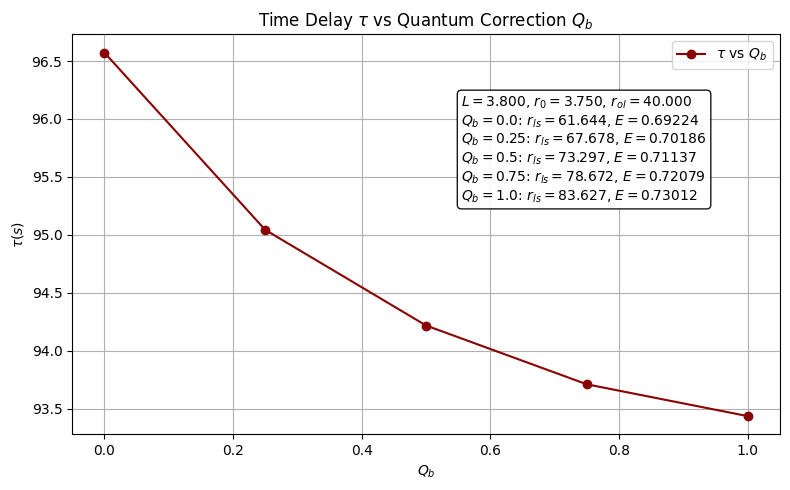

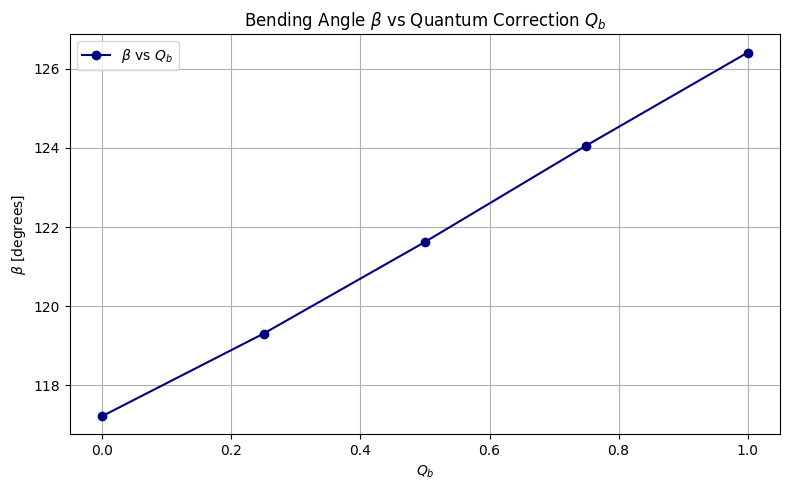

In [177]:

taus = [tau0, tau1, tau2, tau3, tau4]
betas = [-beta0, -beta1, -beta2, -beta3, -beta4]  # reversed sign
Qbs = [Qb0, Qb1, Qb2, Qb3, Qb4]
r_ls_vals = [r_ls0, r_ls1, r_ls2, r_ls3, r_ls4]
betas_deg = np.degrees(betas)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(Qbs, taus, 'o-', color='darkred', label=r'$\tau$ vs $Q_b$')
plt.xlabel(r'$Q_b$')
plt.ylabel(r'$\tau(s)$')
plt.title(r'Time Delay $\tau$ vs Quantum Correction $Q_b$')
plt.grid(True)
plt.legend()

# Annotation box
label_text = (
    rf"$L = {L1:.3f}$, $r_0 = {r0:.3f}$, $r_{{ol}} = {r_ol:.3f}$" + "\n" +
    rf"$Q_b = 0.0$: $r_{{ls}} = {r_ls0:.3f}$, $E = {E0:.5f}$" + "\n" +
    rf"$Q_b = 0.25$: $r_{{ls}} = {r_ls1:.3f}$, $E = {E1:.5f}$" + "\n" +
    rf"$Q_b = 0.5$: $r_{{ls}} = {r_ls2:.3f}$, $E = {E2:.5f}$" + "\n" +
    rf"$Q_b = 0.75$: $r_{{ls}} = {r_ls3:.3f}$, $E = {E3:.5f}$" + "\n" +
    rf"$Q_b = 1.0$: $r_{{ls}} = {r_ls4:.3f}$, $E = {E4:.5f}$"
)

props = dict(boxstyle='round', facecolor='white', alpha=0.9)
plt.text(0.55, 0.85, label_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(Qbs, betas_deg, 'o-', color='navy', label=r'$\beta$ vs $Q_b$')
plt.xlabel(r'$Q_b$')
plt.ylabel(r'$\beta$ [degrees]')
plt.title(r'Bending Angle $\beta$ vs Quantum Correction $Q_b$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



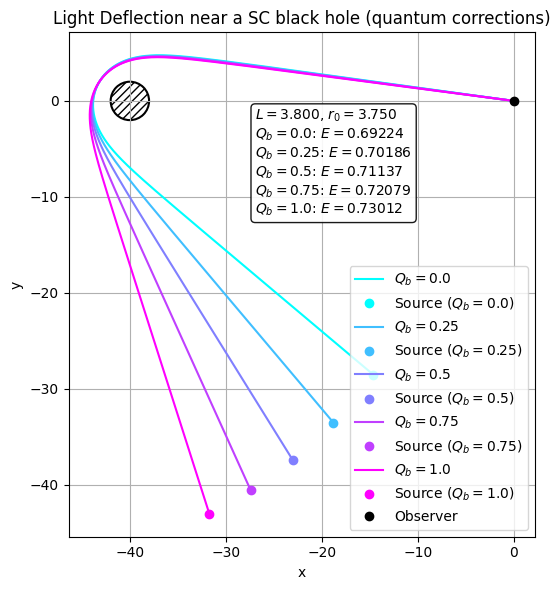

In [173]:
# translate datapoints so observer (first point) is at (0, 0)
x0 = x_vals_0 - x_vals_0[0]
y0 = y_vals_0 - y_vals_0[0]
x1 = x_vals_1 - x_vals_1[0]
y1 = y_vals_1 - y_vals_1[0]
x2 = x_vals_2 - x_vals_2[0]
y2 = y_vals_2 - y_vals_2[0]
x3 = x_vals_3 - x_vals_3[0]
y3 = y_vals_3 - y_vals_3[0]
x4 = x_vals_4 - x_vals_4[0]
y4 = y_vals_4 - y_vals_4[0]
# source positions (last point in each trajectory)
source_0 = (x0[-1], y0[-1])
source_1 = (x1[-1], y1[-1])
source_2 = (x2[-1], y2[-1])
source_3 = (x3[-1], y3[-1])
source_4 = (x4[-1], y4[-1])
#---------------
colors = [cm.cool(q) for q in Qb_vals]  # cool returns RGBA colors

# Plot figure
plt.figure(figsize=(8, 6))

# Plot each trajectory and source with corresponding colormap color
trajectories = [(x0, y0), (x1, y1), (x2, y2), (x3, y3), (x4, y4)]
sources = [source_0, source_1, source_2, source_3, source_4]

for i, (traj, src, q_val, color) in enumerate(zip(trajectories, sources, Qb_vals, colors)):
    plt.plot(traj[0], traj[1], label=rf"$Q_b = {q_val}$", color=color)
    plt.plot(*src, 'o', color=color, label=rf"Source ($Q_b={q_val}$)")

# Observer at (0, 0)
plt.plot(0, 0, 'ko', label='Observer') 

# Lens at (-40, 0), radius = 2.0
lens_x = (-1) * (r_ol * np.cos(phi0))
lens_radius = 2.0
lens_circle = plt.Circle((lens_x, 0), lens_radius, edgecolor='black',
                         facecolor='none', hatch='////', linewidth=1.5)
plt.gca().add_patch(lens_circle)

# Annotation box with LaTeX formatting
label_text = (
    rf"$L = {L1:.3f}$, $r_0 = {r0:.3f}$" + "\n"
    rf"$Q_b = 0.0$: $E = {E0:.5f}$" + "\n"
    rf"$Q_b = 0.25$: $E = {E1:.5f}$" + "\n"
    rf"$Q_b = 0.5$: $E = {E2:.5f}$" + "\n"
    rf"$Q_b = 0.75$: $E = {E3:.5f}$" + "\n"
    rf"$Q_b = 1.0$: $E = {E4:.5f}$"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
plt.text(0.40, 0.85, label_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=props)

# Final formatting
plt.xlabel('x')
plt.ylabel('y')
plt.title('Light Deflection near a SC black hole (quantum corrections)')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()